In [1]:
import warnings
warnings.filterwarnings('ignore')
from keras.layers import Input, Dense, Embedding, Lambda
from keras.optimizers import Adam
from keras.models import Model
import keras.backend as K
import math
import random
import numpy as np
import pandas as pd
from scipy.special import gamma
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import tensorflow as tf
import itertools
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import optim
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

# Generate data

In [2]:
size = 100000
X = np.zeros((size ,10))
sum_X = np.zeros((size))
for i in range(size):
    n = np.random.randint(1,10)
    for j in range(1,n+1):
        X[i,-j] = np.random.randint(1,10)
    sum_X[i] = np.sum(X[i])
    
def gen_test_data(num_examples, length):
    Y = np.zeros((num_examples, length))
    sum_Y = np.zeros((num_examples))
    for i in range(num_examples):
        for j in range(1,length+1):
            Y[i,-j] = np.random.randint(1,10)
        sum_Y[i] = np.sum(Y[i])
    return Y, sum_Y
print('The training set is of size: ', X.shape)

The training set is of size:  (100000, 10)


# Models

In [3]:
def get_stat_model(max_length):
    input_txt = Input(shape=(max_length,))
    x = Dense(1000, activation='relu')(input_txt)
    x = Dense(500, activation='relu')(x)
    x = Dense(250, activation='relu')(x)
    encoded = Dense(1, activation='linear')(x)
    summer = Model(input_txt, encoded)
    adam = Adam(lr=1e-4, epsilon=1e-3)
    summer.compile(optimizer=adam, loss='mae')
    return summer

def get_deepset_model(max_length):
    input_txt = Input(shape=(max_length,))
    x = Embedding(11, 100, mask_zero=True)(input_txt)
    x = Dense(30, activation='tanh')(x)
    Adder = Lambda(lambda x: K.sum(x, axis=1), output_shape=(lambda shape: (shape[0], shape[2])))
    x = Adder(x)
    encoded = Dense(1)(x)
    summer = Model(input_txt, encoded)
    adam = Adam(lr=1e-4, epsilon=1e-3)
    summer.compile(optimizer=adam, loss='mae')
    return summer

# Tests
## Statistics about the data, tested on 1k, 5k, 10k and 50k  training samples (Stat)

The portion of exactly correct predictions for 1000 training samples is:  0.0
The portion of exactly correct predictions for 5000 training samples is:  0.058
The portion of exactly correct predictions for 10000 training samples is:  0.987
The portion of exactly correct predictions for 50000 training samples is:  0.97


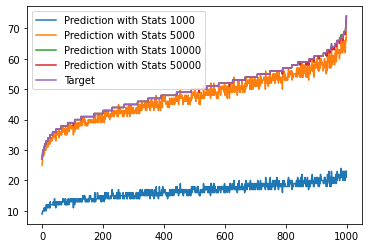

In [24]:
Y, sum_Y = gen_test_data(1000,10)

x = np.array([np.mean(X, 1), np.median(X,1), np.std(X,1)]).transpose()
y = np.array([np.mean(Y, 1), np.median(Y,1), np.std(Y,1)]).transpose()
for k in [1000,5000,10000,50000]:
    model = get_stat_model(3)
    model.fit(x[:k], sum_X[:k], epochs=10, batch_size=128, shuffle=True, validation_split=0.0123456789, verbose =0)
    w_stat = []
    for i in [1,2,3,4]:
        w = model.get_layer(index=i).get_weights()
        w_stat.append(w)

    preds = np.round(model.predict(y, batch_size=128, verbose=0))
    sort = np.argsort(sum_Y)
    preds.shape = sum_Y.shape
    print('The portion of exactly correct predictions for '+str(k)+' training samples is: ', np.mean(preds==sum_Y))
    plt.plot(preds[sort],label='Prediction with Stats '+str(k))
plt.plot(sum_Y[sort], label='Target')
plt.legend()
plt.show()

##  Max order and sum pool with stats on 1k, 5k, 10k and 50k  training samples (MSPS)

The portion of exactly correct predictions for 1000 training samples is:  0.006
The portion of exactly correct predictions for 5000 training samples is:  0.99
The portion of exactly correct predictions for 10000 training samples is:  0.983
The portion of exactly correct predictions for 50000 training samples is:  1.0


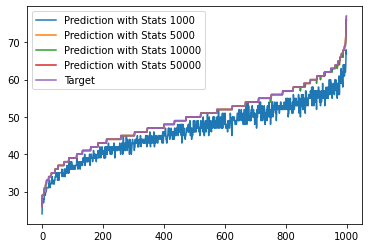

In [42]:
features = 10
Y, sum_Y = gen_test_data(1000,10)

mspx = np.reshape(np.sum(np.reshape(np.sort(X,1),(size*5, features//5)),1), (size, 5))
mspy = np.reshape(np.sum(np.reshape(np.sort(Y,1),(1000*5, features//5)),1), (1000, 5))

x = np.array([np.mean(X, 1), np.median(X,1), np.std(X,1)]).transpose()
y = np.array([np.mean(Y, 1), np.median(Y,1), np.std(Y,1)]).transpose()

x = np.concatenate((x, mspx),1)
y = np.concatenate((y, mspy),1)

for k in [1000,5000,10000,50000]:
    model = get_stat_model(8)
    model.fit(x[:k], sum_X[:k], epochs=10, batch_size=128, shuffle=True, validation_split=0.0123456789, verbose =0)
    w_msps = []
    for i in [1,2,3,4]:
        w = model.get_layer(index=i).get_weights()
        w_msps.append(w)

    preds = np.round(model.predict(y, batch_size=128, verbose=0))
    sort = np.argsort(sum_Y)
    preds.shape = sum_Y.shape
    print('The portion of exactly correct predictions for '+str(k)+' training samples is: ', np.mean(preds==sum_Y))
    plt.plot(preds[sort],label='Prediction with Stats '+str(k))
plt.plot(sum_Y[sort], label='Target')
plt.legend()
plt.show()

##  Max order and sum pool on 1k, 5k, 10k and 50k  training samples (MSP)

The portion of exactly correct predictions for 1000 training samples is:  0.0
The portion of exactly correct predictions for 5000 training samples is:  0.988
The portion of exactly correct predictions for 10000 training samples is:  1.0
The portion of exactly correct predictions for 50000 training samples is:  1.0


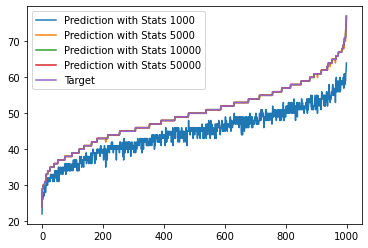

In [43]:
features = 10
Y, sum_Y = gen_test_data(1000,10)

mspx = np.reshape(np.sum(np.reshape(np.sort(X,1),(size*5, features//5)),1), (size, 5))
mspy = np.reshape(np.sum(np.reshape(np.sort(Y,1),(1000*5, features//5)),1), (1000, 5))

x,y = mspx,mspy

for k in [1000,5000,10000,50000]:
    model = get_stat_model(5)
    model.fit(x[:k], sum_X[:k], epochs=10, batch_size=128, shuffle=True, validation_split=0.0123456789, verbose =0)
    w_msp = []
    for i in [1,2,3,4]:
        w = model.get_layer(index=i).get_weights()
        w_msp.append(w)

    preds = np.round(model.predict(y, batch_size=128, verbose=0))
    sort = np.argsort(sum_Y)
    preds.shape = sum_Y.shape
    print('The portion of exactly correct predictions for '+str(k)+' training samples is: ', np.mean(preds==sum_Y))
    plt.plot(preds[sort],label='Prediction with Stats '+str(k))
plt.plot(sum_Y[sort], label='Target')
plt.legend()
plt.show()

## Deepsets tested on 1k, 5k, 10k and 50k  training samples

The portion of exactly correct predictions for 1000 training samples is:  0.0
The portion of exactly correct predictions for 5000 training samples is:  0.0
The portion of exactly correct predictions for 10000 training samples is:  0.076
The portion of exactly correct predictions for 50000 training samples is:  1.0


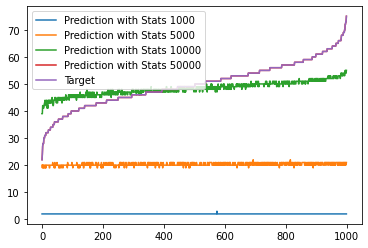

In [5]:
Y, sum_Y = gen_test_data(1000,10)

for k in [1000,5000,10000,50000]:
    model = get_deepset_model(10)
    model.fit(X[:k], sum_X[:k], epochs=10, batch_size=128, shuffle=True, validation_split=0.0123456789, verbose =0)

    w_ds=[]
    for i in [1,2,4]:
        w = model.get_layer(index=i).get_weights()
        w_ds.append(w)
    
    preds = np.round(model.predict(Y, batch_size=128, verbose=0))
    sort = np.argsort(sum_Y)
    preds.shape = sum_Y.shape
    print('The portion of exactly correct predictions for '+str(k)+' training samples is: ', np.mean(preds==sum_Y))
    plt.plot(preds[sort],label='Prediction with Stats '+str(k))
plt.plot(sum_Y[sort], label='Target')
plt.legend()
plt.show()

## Testing both models on a dataset with different size:

Deepset error:  0.010274456024169923
Stat model error:  49.647
MSP model error:  0.0
MSPS model error:  4.138


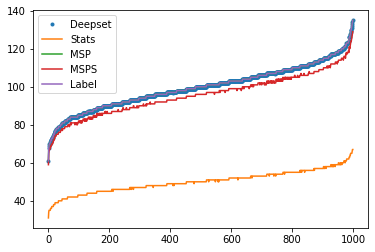

In [45]:
features = 20
Y, sum_Y = gen_test_data(1000,features)
y = np.array([np.mean(Y, 1), np.median(Y,1), np.std(Y,1)]).transpose()

sort = np.argsort(sum_Y)

model = get_deepset_model(20)
for i, idx in enumerate([1,2,4]):
    model.get_layer(index=idx).set_weights(w_ds[i])
preds = model.predict(Y, batch_size=128, verbose=0)
preds.shape = sum_Y.shape
print('Deepset error: ',np.mean(np.abs(preds-sum_Y)))
plt.plot(preds[sort],'.', label='Deepset')

model = get_stat_model(3)
for i, idx in enumerate([1,2,3,4]):
    model.get_layer(index=idx).set_weights(w_stat[i])
    
preds = np.round(model.predict(y, batch_size=128, verbose=0))
preds.shape = sum_Y.shape
print('Stat model error: ',np.mean(np.abs(preds-sum_Y)))
plt.plot(preds[sort],label='Stats')

mspy = np.reshape(np.sum(np.reshape(np.sort(Y,1),(1000*5, features//5)),1), (1000, 5))
model = get_stat_model(5)
for i, idx in enumerate([1,2,3,4]):
    model.get_layer(index=idx).set_weights(w_msp[i])
preds = np.round(model.predict(mspy, batch_size=128, verbose=0))
preds.shape = sum_Y.shape
print('MSP model error: ',np.mean(np.abs(preds-sum_Y)))
plt.plot(preds[sort],label='MSP')


y = np.concatenate((y, mspy),1)

model = get_stat_model(8)
for i, idx in enumerate([1,2,3,4]):
    model.get_layer(index=idx).set_weights(w_msps[i])
    
preds = np.round(model.predict(y, batch_size=128, verbose=0))
preds.shape = sum_Y.shape
print('MSPS model error: ',np.mean(np.abs(preds-sum_Y)))
plt.plot(preds[sort],label='MSPS')


plt.plot(sum_Y[sort], label='Label')
plt.legend()
plt.show()